# morph-var 2

## Normalize landform-normal profiles

This is the second of five notebooks outlining the algorithm we used to quantify the morphologic variability of a linear landform. In this notebook, we use the output of the first notebook (morph-var 1), which is a folder containing text files with the coordinates and elevation data of points along each landform-normal profile. This notebook focuses on formatting and normalizing the profile data, so that they are ready for use in our classification algorithm (morph-var 3). 

To normalize the profiles, we calculate the two-dimensional coordinates of each profile, automatically determine the position of the crest and toe of the scarp, crop the the profile between the crest and the toe and normalize the profile by the scarp height. We store the new profiles in text files.

To calculate the curvature along the profile, we use geomdl, a pure Python, object-oriented B-Spline and NURBS library.

Bingol, O. R., & Krishnamurthy, A. (2019). NURBS-Python: An open-source object-oriented NURBS modeling framework in Python. SoftwareX, 9, 85-94.

### Packages and libraries

In [1]:
import numpy as np
import pandas as pd
import os, re
import matplotlib.pyplot as plt
from geomdl import BSpline, utilities, evaluators, operations

In [8]:
%matplotlib qt

### Functions

#### Calculate angle between two vectors

In [2]:
def calculate_angle(ba,bc): #the order of ba and bc in the inputs determines the direction inwhich the angle is calculated
    
    ang_a = np.arctan2(*ba[::-1])
    ang_b = np.arctan2(*bc[::-1])
    
    return np.rad2deg((ang_b - ang_a) % (2 * np.pi)) #returns results in degrees

#### Finding the crest of the scarp

In [3]:
def find_crest(x,y,k,profile_names):
    for a in profile_names:
        # Add coordinate values, curvature and index values into a dataframe 'data'
        x_temp = pd.Series(x[a])
        y_temp = pd.Series(y[a])
        original_index = pd.Series(list(x[a].index))
        k_values = pd.Series(k[a])
        frame = { 'x': x_temp, 'y': y_temp,'k': k_values,'original_index': original_index } 
        data = pd.DataFrame(frame)

        #Define x_start and y_start as the coordinates of the first point in the profile
        x_start = x_temp.iloc[0]
        y_start = y_temp.iloc[0]

        #Define x_end and y_end as the coordinates of the last point in the profile
        x_end = x_temp.iloc[-1]
        y_end = y_temp.iloc[-1]

        # Find the indices of the local minima in the curvature values
        index_k_local_minima = (np.diff(np.sign(np.diff(k_values))) > 0).nonzero()[0] + 1 

        # Find the entries in 'data' that correspond to these minima
        data_k_minima = data.iloc[list(index_k_local_minima)]
        data_k_minima = data_k_minima.reset_index(drop=True)

        #Assuming that the profile is roughly centered on the fault scarp line, mask entries in the last quarter of the profile
        data_k_minima = data_k_minima[data_k_minima['y']>y_start/4]
        
        if len(data_k_minima['x'].values) == 1:
            crest_x=data_k_minima['x'][0]
            crest_y=data_k_minima['y'][0]
            crest_idx=int(data_k_minima['original_index'][0])
            crest_temp=pd.Series([crest_x,crest_y,crest_idx])
            minima_x_temp=data_k_minima['x']
            minima_y_temp=data_k_minima['y']
            crest[a]=crest_temp
            minima_x[a]=minima_x_temp
            minima_y[a]=minima_y_temp
        elif len(data_k_minima['x'].values) == 0:
            crest_x = x_start
            crest_y = y_start
            crest_idx=0
        else:

            #Define X1 and Y1 as the coordinates of the profile minima
            X1=data_k_minima['x']
            Y1=data_k_minima['y']

            # Define data series for angle measurements centered on the potential crest points (profile minima).
            k_minima_angle=pd.Series(np.nan, index=list(X1.index),name='angle')

            #Calculate angles
            for n in list(X1.index):
                c=np.array([X1[n],Y1[n]])

                # m determines the number of points before and after each minima to use as an interval for the angle
                m=10

                #If m exceeds the number of points that come after the minima, use the end point for the angle calculation.
                if int(data_k_minima['original_index'][n]+m)>=len(x_temp):
                    d=np.array([x_end,y_end])
                #Otherwise, use the point that is m points away from the minima in question as the furthest point for the angle calculation.
                else: 
                    d=np.array([x_temp[int(data_k_minima['original_index'][n]+m)],y_temp[int(data_k_minima['original_index'][n]+m)]])

                #If m exceeds the number of points that come before the minima, use the start point for the angle calculation.
                if int(data_k_minima['original_index'][n]-m)<=0:
                    b=np.array([x_start,y_start])
                #Otherwise, use the point that is m points away from the minima in question as the closest point for the angle calculation.
                else: 
                    b=np.array([x_temp[int(data_k_minima['original_index'][n]-m)],y_temp[int(data_k_minima['original_index'][n]-m)]])

                #calculate vector coordinates
                cb=b-c
                cd=d-c

                #Calculate angle between the three points
                angle_temp=calculate_angle(cb,cd)
                k_minima_angle[n]=angle_temp

            #Determine the profile minima with the smallest angle {bcd}
            k_minima_y_norm=1-(data_k_minima['y']-data_k_minima['y'].min())/((data_k_minima['y']-data_k_minima['y'].min()).max())
            k_minima_angle_norm=(k_minima_angle-k_minima_angle.min())/((k_minima_angle-k_minima_angle.min()).max())
            k_minima_sum=4*k_minima_angle_norm+k_minima_y_norm
            idx_min=k_minima_sum.idxmin()

            # Store the coordinates of this point as those of the crest
            crest_x=data_k_minima['x'][idx_min]
            crest_y=data_k_minima['y'][idx_min]
            crest_idx=int(data_k_minima['original_index'][idx_min])
            crest_temp=pd.Series([crest_x,crest_y,crest_idx])
            minima_x_temp=data_k_minima['x']
            minima_y_temp=data_k_minima['y']
            crest[a]=crest_temp
            minima_x[a]=minima_x_temp
            minima_y[a]=minima_y_temp
    
    return crest, minima_x, minima_y

#### Finding the toe of the scarp

In [4]:
def find_toe(x,y,k,profile_names):
    for a in profile_names:
        # Add coordinate values, curvature and index values into a dataframe 'data'
        x_temp = pd.Series(x[a])
        y_temp = pd.Series(y[a])
        original_index = pd.Series(list(x[a].index))
        k_values = pd.Series(k[a])
        frame = { 'x': x_temp, 'y': y_temp,'k': k_values,'original_index': original_index } 
        data = pd.DataFrame(frame)

        # Find indices of the local maxima in curvature values
        index_k_local_maxima = (np.diff(np.sign(np.diff(k_values))) < 0).nonzero()[0] + 1

        # Find the entries in 'data' that correspond to these maxima
        data_k_maxima = data.iloc[list(index_k_local_maxima)]
        data_k_maxima = data_k_maxima.reset_index(drop=True)

        #Define x_start and y_start as the coordinates of the first point in the profile
        x_start = x_temp[0]
        y_start = y_temp[0]

        #Define x_end, y_end and idx_end as the coordinates and index of the last point in the profile
        x_end = x_temp.iloc[-1]
        y_end = y_temp.iloc[-1]
        idx_end=list(x_temp.index)[-1]

        #Define x_crest and y_crest as the coordinates and index of the profile crest
        x_crest=crest[a].iloc[0]
        y_crest=crest[a].iloc[1]

        # Mask values with index before crest and with a height larger than 3/4 of the maximum height along the profile
        idx_crest = crest[a].iloc[2]
        data_k_maxima = data_k_maxima[data_k_maxima['original_index']>idx_crest]
        data_k_maxima = data_k_maxima[data_k_maxima['y']<(3*y_temp.max()/4)]

        #Define X1 and Y1 as the coordinates corresponding to the profile maxima
        X1 = data_k_maxima['x']
        Y1 = data_k_maxima['y']

        #If there are no points corresponding to profile maxima after masking, select end point as toe of scarp
        if data_k_maxima.empty==True:
            toe_temp1=pd.Series([x_end,y_end,idx_end])
            toe[a]=toe_temp1

        #If 1 profile maxima remains, choose that point as the scarp toe.
        elif len(data_k_maxima)==1:
            toe_x = data_k_maxima['x'].iloc[0]
            toe_y = data_k_maxima['y'].iloc[0]
            toe_idx = data_k_maxima['original_index'].iloc[0]
            toe_temp = pd.Series([toe_x,toe_y,toe_idx])
            toe[a]=toe_temp
        #Otherwise, calculate the angle between the scarp crest, the profile maxima, and a point with x-coordinate equal to that of the end point, and a y-coordinate equal to that of the profile y-coordinate minimum. This is to prevent any errors if the end point is higher than the maxima.    
        else: 
            #Define data series to store angle measurements centered on profile maxima
            k_maxima_angle=pd.Series(np.nan, index=list(X1.index),name='angle')

            for n in list(X1.index):
                b=np.array([x_crest,y_crest])
                c=np.array([x_start,y_temp.max()])
                d=np.array([X1[n],Y1[n]])

                cb=b-c
                cd=d-c

                #Calculate angle {bcd}
                angle_temp=calculate_angle(cd,cb)
                k_maxima_angle[n]=angle_temp

            #Determine the profile maxima with the smallest angle {bcd}
            k_maxima_angle=k_maxima_angle[k_maxima_angle<180]
            if k_maxima_angle.empty==True:
                toe_temp1=pd.Series([x_end,y_end,idx_end])
                toe[a]=toe_temp1
            else:

                idx_sum_min=k_maxima_angle.idxmax()
                data_k_maxima_angle=pd.concat([data_k_maxima,k_maxima_angle],axis=1)#.reset_index(drop=True)
                toe_x=data_k_maxima_angle['x'][idx_sum_min]
                toe_y=data_k_maxima_angle['y'][idx_sum_min]
                toe_idx=data_k_maxima_angle['original_index'][idx_sum_min]
                toe_temp2=pd.Series([toe_x,toe_y,toe_idx])
                maxima_x[a]=data_k_maxima['x']
                maxima_y[a]=data_k_maxima['y']
                toe[a]=toe_temp2
    return toe, maxima_x, maxima_y

#### Calculate scarp height

In [5]:
#Define function to calculate scarp height based on indices of crest and toe and Z
def find_height_idx(idx_1,idx_2,z_data,a):
    return z_data[a].iloc[idx_1[a][0]]-z_data[a].iloc[idx_2[a][0]]

#### Distance along scarp

In [6]:
#Define function to calculate distance between crests
def find_distance(x,y):
    return np.hstack((0,np.cumsum(((x[1:]-x[:-1])**2+(y[1:]-y[:-1])**2)**0.5)))

### Import profile data

In [7]:
# Define function load_data to read x,y,z data from text files into three separate dataframes (dataclass_x,dataclass_y,dataclass_z) for each class. Rows of the dataframes indicate the number of points in a profile, columns indicate the index of the profiles.  
def load_data(data,path): # inputs are a regular expression indicating text files names ('data'), and the directory path to thses files ('path')
    data_x_temp = []
    data_y_temp = []
    data_z_temp = []
    filenames = [filename for filename in os.listdir(path) if re.match(data, filename)]#create list of desired file names based on regular expression
    for file in filenames:
            # Load x-coordinate data from files matching filenames
            data_x_temp.append(
                list(pd.read_csv(path+"/"+file)['Easting']))
            # Load y-coordinate data from files matching filenames
            data_y_temp.append(
                list(pd.read_csv(path+"/"+file)['Westing']))
            # Load z-coordinate data from files matching filenames
            data_z_temp.append(
                list(pd.read_csv(path+"/"+file)['elevation'])) 
    # Create 3 dataframes for x,y, and z-coordinate data, with the text file names as the columns
    dataclass_x = pd.DataFrame(data_x_temp).transpose() 
    dataclass_y = pd.DataFrame(data_y_temp).transpose()
    dataclass_z = pd.DataFrame(data_z_temp).transpose()
    dataclass_x.columns = filenames
    dataclass_y.columns = filenames
    dataclass_z.columns = filenames
    return dataclass_x, dataclass_y, dataclass_z

In [8]:
# Use load_data with desired file name regular expression and directory path to text files with 3-D profile coordinates (1 file per profile).
landform_name='./result/profile_shapefile/DE001'
files = ".*.txt"
folder = landform_name+'_raw_profiles/'
path = folder
(data_x, data_y, data_z) = load_data(files,path)

In [9]:
#Reorder profiles so that the profile numbers are sequential and ascending.
col1 = data_x.columns.sort_values()
col2 = data_y.columns.sort_values()
col3 = data_z.columns.sort_values()
data_x = data_x[col1]
data_y = data_y[col2]
data_z = data_z[col3]

In [10]:
#Obtain list of all profiles names, to iterate through the profiles
profile_names = list(data_x.columns)
#Remove any empty profiles
profile_names = [a for a in profile_names if len(data_x[a].dropna())>0]
data_x=data_x[profile_names]
data_y=data_y[profile_names]
data_z=data_z[profile_names]
#Obtain list of all unique landform names, to determine the number of landforms present in dataset and to separate the scarps by landform.
landform_names=[]
for a in profile_names:
    m = re.search('^(.*)[_]', a) #Isolate the portion of the profile file name that contains the landform name (everything before the last underscore, with file names following this structure:'LandformName_ProfileNumber.txt')
    if m:
        found = m.group(1)
        landform_names.append(found)
landform_names=list(set(landform_names)) #Convert to set then back to list to get unique landform names.

## Format profile coordinates

In [11]:
# In order to obtain the elevation component of the scarp profile (Z), normalize the data_z values for each landform so that the minimum value is 0.
Z=[]
filenames = [filename for filename in profile_names if re.match(f'{landform_names}.*.txt', filename)]
for a in filenames:
    data_z_temp=data_z[a]
    data_z_min=data_z[a].min()
    Z_temp = data_z_temp - data_z_min
    Z.append(Z_temp)
Z=pd.DataFrame(Z).transpose()
Z.columns=filenames
col_sorted=Z.columns.sort_values()
Z=Z[col_sorted]

In [12]:
# All profiles need to be in the same orientation (crest closest to origin), so we need to determine which profiles are in the incorrect orientation so that we can reverse them later.
lst = []
[rows,columns] = Z.shape
for n in range(columns):
    idx = Z.apply(pd.Series.last_valid_index)
    column_name = Z.columns[n]
    if Z.values[0,n] < Z.values[idx[n],n]: #find the filenames that have profiles where the first value of Z is lower than the last
        lst.append(column_name) #store in list 'lst
        
# In order to obtain the distance component of the scarp profile (M), we need to calculate the cummulative 2D profile distances between points using data_x and data_y (M_temp).
# However, if the profiles are in the reversed order, we need to flip them and use the distance between the points (M_dist) to reconstruct the profile.
# The final distance measurements are stored in dataframe M.

# Calculate 2D profile distance using data_x and data_y, store in dataframe M_temp.
M_temp = pd.DataFrame(((data_x.loc[1:,:]-data_x.loc[0])**2 +(data_y.loc[1:,:]-data_y.loc[0])**2)**0.5)
df_0=pd.DataFrame(np.zeros((1,M_temp.shape[1])),columns = M_temp.columns)
M_temp = pd.concat([df_0,M_temp])


# Calculate horizontal distance between points (M_dist) by looking at difference between points in M_temp.
M_dist = pd.DataFrame()
M = pd.DataFrame()
M2 = M_temp.loc[1:rows+1]
M2.index -= 1
M1 = M_temp.loc[0:rows]
M_dist = M2 - M1
M_dist = pd.concat([df_0,M_dist])
M_dist = M_dist.reset_index(drop=True).drop(M_dist.tail(1).index)

# Change the order of the Z and M_dist measurements for the reversed profiles and calculate the cummulative sum of M_dist, store in M.
for b in lst:
    Z_temp_flip_array = np.flipud(Z[b].to_numpy())
    Z_temp_flip_array = Z_temp_flip_array[~np.isnan(Z_temp_flip_array)]
    M_dist_flip_array = np.flipud(M_dist[b].to_numpy())
    M_dist_flip_array = M_dist_flip_array[~np.isnan(M_dist_flip_array)]
    Z[b] = pd.Series(Z_temp_flip_array)
    M_dist[b] = pd.Series(M_dist_flip_array)
M = M_dist.cumsum()
M = M[col_sorted]

In [13]:
path="All_2D_raw/"
if os.path.exists(path)==False: 
    os.mkdir(path)

In [14]:
for a in landform_names:
    i = 0
    landform_profile_names=[s for s in profile_names if f"{a}" in s]
    for b in landform_profile_names:
        scarp_name = a
        profile = pd.concat([M[b],Z[b]], axis =1, join = 'outer', ignore_index = False)
        profile.columns = ['M','Z']
        file = scarp_name+f'_{i}.txt'
        i += 1
        profile.to_csv(path+file)

In [15]:
Z_norm=pd.DataFrame([Z[a]/Z[a].max() for a in list(M.columns)]).transpose()
M_norm=pd.DataFrame([M[a]/Z[a].max() for a in list(M.columns)]).transpose()

In [16]:
path="All_2D_normalized/"
if os.path.exists(path)==False: 
    os.mkdir(path)

In [17]:
for a in landform_names:
    i = 0
    landform_profile_names=[s for s in profile_names if f"{a}" in s]
    for b in landform_profile_names:
        scarp_name = a
        profile = pd.concat([M_norm[b],Z_norm[b]], axis =1, join = 'outer', ignore_index = False)
        profile.columns = ['M_norm','Z_norm']
        file = scarp_name+f'_norm_{i}.txt'
        i += 1
        profile.to_csv(path+file)

## Fit B-spline to 2-D profiles and calculate curvature

In [18]:
# Create dataframes to store the points at which the curve was evaluated (x and y) and the curvature at those points (k).
x = pd.DataFrame()
y = pd.DataFrame()
k = pd.DataFrame()

#Set evaluation interval (=total number of observations in {x,y,k})
evaluate = pd.Series(np.linspace(0,1,100))

#Set the spacing at which M is evaluated
spacing = int(len(M))

In [19]:
# For each profile, fit the data with a B-spline, calculate its derivatives, calculate curvature.
x=[]
y=[]
k=[]
for a in profile_names:
    # M and Z are the control points, convert to list of coordinate tuples L
    if len(M[a].dropna())/spacing>5:
        M_temp = M[a].dropna()[0::spacing]
        Z_temp = Z[a].dropna()[0::spacing]
    else:
        M_temp= M[a].dropna()
        Z_temp=Z[a].dropna()
    L = list(zip(M_temp,Z_temp)) # zip M_temp and Z_temp to create list of tuples of points
    # Create B-Spline curve
    curve = BSpline.Curve() # define the BSpline curve
    curve.degree =3# define the degree of the curve
    curve.ctrlpts = L # set control points as list of tuples L
    curve.knotvector = utilities.generate_knot_vector(curve.degree, len(curve.ctrlpts)) # auto-generate knot vector
    curve.evaluate() # evaluate curve
    # Calculate x,y coordinates and derivatives of curve at u values
    x_temp = []
    y_temp = []
    k_temp = []
    for i in evaluate.iloc[:-1]:
        ders = curve.derivatives(i, order = 2) # calculate 1st and 2nd derivatives of the curve at u, returns 3 tuples defined below.
        x_temp2 = ders[0][0] # x-position at u
        y_temp2 = ders[0][1] # y-position at u
        der1x = ders[1][0] # 1st derivative with respect to x
        der1y = ders[1][1] # 1st derivative with respect to y
        der2x = ders[2][0] # 2nd derivative with respect to x
        der2y = ders[2][1] # 2nd derivative with respect to y
        k_temp2 = ((der1x*der2y)-(der1y*der2x))/((((der1x)**2)+((der1y)**2))**(3/2)) # calculate curvature using formula for parametric curves.
        k_temp.append(k_temp2)
        x_temp.append(x_temp2)
        y_temp.append(y_temp2)
    x.append(x_temp)
    y.append(y_temp)
    k.append(k_temp)
x=pd.DataFrame(x).transpose()
x.columns=filenames
y=pd.DataFrame(y).transpose()
y.columns=filenames
k=pd.DataFrame(k).transpose()
k.columns=filenames

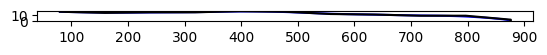

In [20]:
n=0
a=0
filenames = [filename for filename in filenames if re.match(f'{landform_names[n]}.*.txt', filename)]
fig,ax=plt.subplots()
ax.plot(x[filenames[a]],y[filenames[a]],c='b')
ax.plot(M[filenames[a]],Z[filenames[a]],c='k')

ax.set_aspect('equal')

## Determine position of crest and toe

#### Determine position of scarp crest

In [21]:
# Define dataframe for the 2D coordinates and the index of the crest of the scarp.
crest = pd.DataFrame(columns=profile_names,index=[0,1,2])
minima_x=pd.DataFrame(columns=profile_names,index=range(0,1000))
minima_y=pd.DataFrame(columns=profile_names,index=range(0,1000))

In [22]:
crest, minima_x, minima_y=find_crest(x,y,k,profile_names)

In [23]:
crest

,DE001_000000.txt,DE001_000001.txt,DE001_000002.txt,DE001_000003.txt,DE001_000004.txt,DE001_000005.txt,DE001_000006.txt,DE001_000007.txt,DE001_000008.txt,DE001_000009.txt,...,DE001_000255.txt,DE001_000256.txt,DE001_000257.txt,DE001_000258.txt,DE001_000259.txt,DE001_000260.txt,DE001_000261.txt,DE001_000262.txt,DE001_000263.txt,DE001_000264.txt
0,803.430995,398.395535,166.756418,318.716428,398.395535,478.074642,179.891598,191.949224,478.074642,557.753749,...,239.037321,478.074642,637.432856,398.395535,637.432856,318.716428,557.753749,318.716428,179.891598,478.074642
1,7.250000,11.500000,38.090033,45.666667,39.333333,45.333333,162.969947,151.345167,91.833333,60.833333,...,10.333333,5.500000,14.333333,11.000000,7.666667,24.166667,36.333333,30.666667,35.553719,16.000000
2,88.000000,33.000000,5.000000,22.000000,33.000000,44.000000,6.000000,7.000000,44.000000,55.000000,...,22.000000,44.000000,66.000000,33.000000,77.000000,22.000000,55.000000,22.000000,6.000000,44.000000


In [24]:
profile_names=[a for a in profile_names if len(crest[a].dropna())!=0]
crest=crest[profile_names]

#### Determine position of scarp toe

In [25]:
# Define dataframe for the 2D coordinates and the index of the toe of the scarp.
toe = pd.DataFrame(columns=profile_names,index=[0,1,2])
maxima_x=pd.DataFrame(columns=profile_names,index=range(0,1000))
maxima_y=pd.DataFrame(columns=profile_names,index=range(0,1000))

In [26]:
toe, maxima_x, maxima_y=find_toe(x,y,k,profile_names)

In [27]:
toe

,DE001_000000.txt,DE001_000001.txt,DE001_000002.txt,DE001_000003.txt,DE001_000004.txt,DE001_000005.txt,DE001_000006.txt,DE001_000007.txt,DE001_000008.txt,DE001_000009.txt,...,DE001_000255.txt,DE001_000256.txt,DE001_000257.txt,DE001_000258.txt,DE001_000259.txt,DE001_000260.txt,DE001_000261.txt,DE001_000262.txt,DE001_000263.txt,DE001_000264.txt
0,821.919022,557.753749,258.213785,803.430995,875.517340,875.51734,478.074642,318.716428,875.517340,717.111963,...,478.074642,746.405458,803.430995,557.753749,723.751888,398.395535,717.111963,398.395535,637.432856,717.111963
1,6.141435,5.833333,25.864638,9.000000,1.373466,2.10124,60.833333,102.833333,8.202667,18.666667,...,2.833333,0.109942,7.583333,6.500000,2.416667,10.166667,10.833333,27.000000,20.833333,6.500000
2,90.000000,55.000000,14.000000,88.000000,98.000000,98.00000,44.000000,22.000000,98.000000,77.000000,...,55.000000,81.000000,88.000000,55.000000,88.000000,33.000000,77.000000,33.000000,66.000000,77.000000


In [28]:
M=M[profile_names]
Z=Z[profile_names]

#### Find closest indices in unsmoothed profile to those of the crest and toe of the B-spline profiles



In [29]:
#Define function to find index of the closest matching point in M.
def find_closest_index(c,d,a):
    idx_temp = [abs(c[b]-d[b]).idxmin() for b in a]   
    return idx_temp

In [30]:
#Define dataframes for indices of crest and toe
idx_crest=pd.DataFrame()
idx_toe=pd.DataFrame()

#Find the index of the crest and toe in M
index_crest_temp = find_closest_index(crest.iloc[0],M,profile_names)
index_toe_temp = find_closest_index(toe.iloc[0],M,profile_names)
idx_crest = pd.DataFrame(index_crest_temp).transpose()
idx_crest.columns=profile_names
idx_toe = pd.DataFrame(index_toe_temp).transpose()
idx_toe.columns=profile_names

### Calculate scarp height and distance along scarp

In [31]:
height = pd.DataFrame([find_height_idx(idx_crest,idx_toe,Z,a) for a in idx_crest.columns])
height.index = idx_crest.columns

In [32]:
distance_crests = pd.DataFrame(find_distance(crest.loc[0,:].values,crest.loc[1,:].values))
distance_crests.index=height.index

In [33]:
height_save=height[0].reset_index(drop=True)
height_names=pd.Series(height.index,name='filename')
heights=pd.concat([height_save,height_names],axis=1)
heights.to_csv(landform_name+"_height.txt")

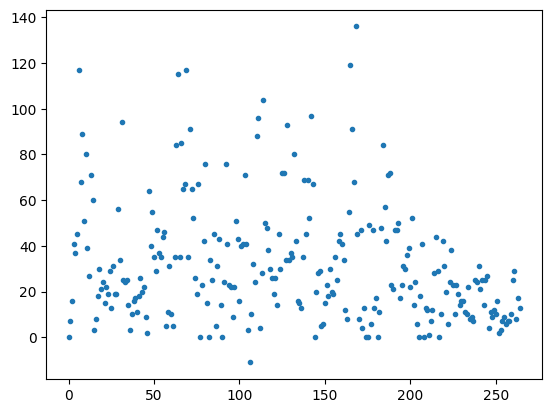

In [34]:
plt.plot(height_save,'.')

## Crop and normalize profiles

#### Crop profiles

In [35]:
M_crop=[]#pd.DataFrame(index=range(len(M)))
Z_crop=[]#pd.DataFrame(index=range(len(M)))
for a in profile_names:
    M_temp=M[a]
    Z_temp=Z[a]
    idx_crest_temp=idx_crest[a]
    idx_toe_temp=idx_toe[a]
    M_crop_1_temp=M_temp.iloc[idx_crest_temp[0]:idx_toe_temp[0]].reset_index(drop=True)
    Z_crop_1_temp=Z_temp.iloc[idx_crest_temp[0]:idx_toe_temp[0]].reset_index(drop=True)
    M_crop.append(M_crop_1_temp)
    Z_crop.append(Z_crop_1_temp)
M_crop=pd.DataFrame(M_crop).transpose()
Z_crop=pd.DataFrame(Z_crop).transpose()

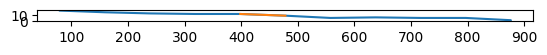

In [36]:
a=1

fig,ax=plt.subplots()

ax.plot(M.iloc[:,a],Z.iloc[:,a])
ax.plot(M_crop.iloc[:,a],Z_crop.iloc[:,a])
ax.set_aspect('equal')

# Normalize cropped profiles

In [37]:
M_crop_norm = []
Z_crop_norm = []

for a in profile_names:
    M_crop_norm_temp = M_crop[a]-M_crop[a].min()
    Z_crop_norm_temp = Z_crop[a]-Z_crop[a].min()
    M_crop_norm_temp=M_crop_norm_temp/Z_crop_norm_temp.max()
    Z_crop_norm_temp=Z_crop_norm_temp/Z_crop_norm_temp.max()
    M_crop_norm.append(M_crop_norm_temp)
    Z_crop_norm.append(Z_crop_norm_temp)
M_crop_norm=pd.DataFrame(M_crop_norm).transpose()
Z_crop_norm=pd.DataFrame(Z_crop_norm).transpose()

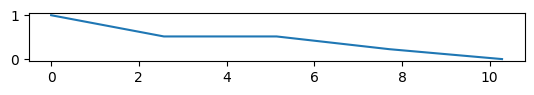

In [38]:
a=50

fig,ax=plt.subplots()

ax.plot(M_crop_norm.iloc[:,a],Z_crop_norm.iloc[:,a])
ax.set_aspect('equal')

## Output files

In [39]:
path=landform_name+'_cropped_normalized_profiles/'
if os.path.exists(path)==False: 
    os.mkdir(path)

In [40]:
for a in landform_names:
    i = 0
    landform_profile_names=[s for s in profile_names if f"{a}" in s]
    for b in landform_profile_names:
        scarp_name = a
        profile = pd.concat([M_crop_norm[b],Z_crop_norm[b]], axis =1, join = 'outer', ignore_index = False)
        profile.columns = ['M_crop_norm','Z_crop_norm']
        file = scarp_name+f'_cropnorm_{i}.txt'
        i += 1
        profile.to_csv(path+file)